In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import heatmap

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
# data = pd.read_csv("../data/final_data.csv.gz")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
df_ = data.to_dataframe().reset_index() 

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

def knn(X_train, y_train, X_test):
    k_range = list(range(1, 10))
    param_grid = dict(n_neighbors=k_range)
    knn_model = KNeighborsRegressor()
    grid = GridSearchCV(knn_model, param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=False,verbose=0)
    grid_search=grid.fit(X_train, y_train)
#     knn_model.fit(X_train, y_train)
    
    knn_preds = grid_search.predict(X_test)
#     knn_preds = knn_model.predict(X_test)
    
    return knn_preds
    

2022-01-01 00:30:00	86.45446696696698


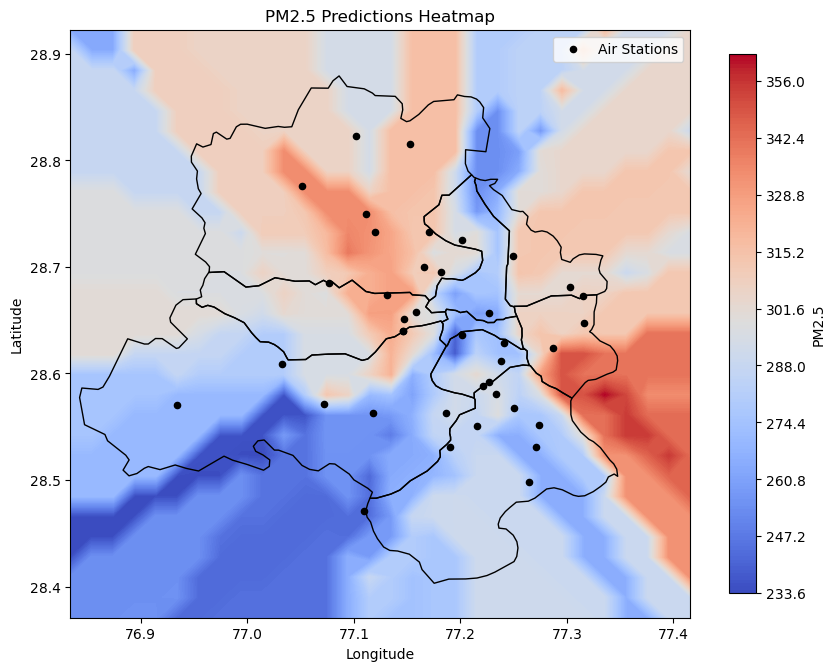

2022-02-01 00:30:00	45.9040704887218


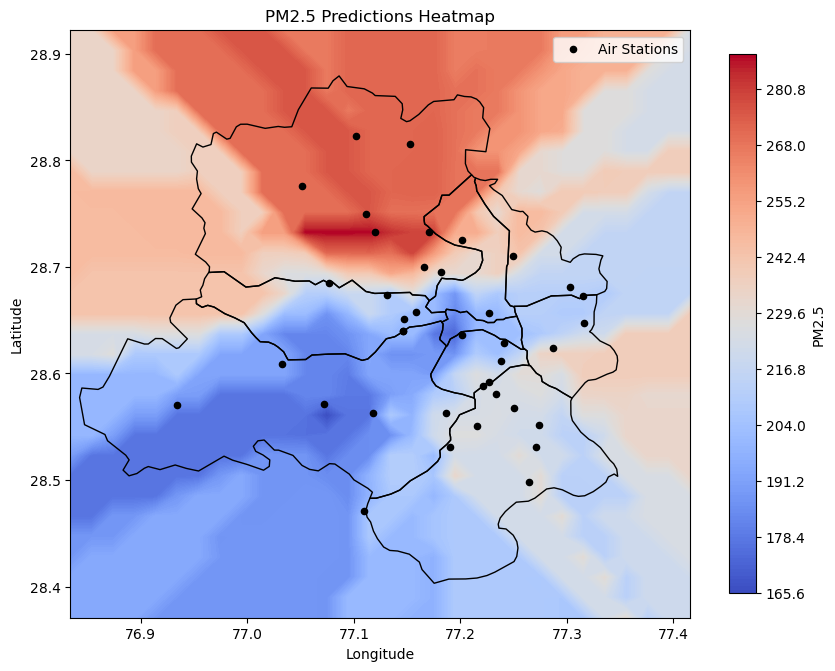

2022-03-01 00:30:00	27.06034356725147


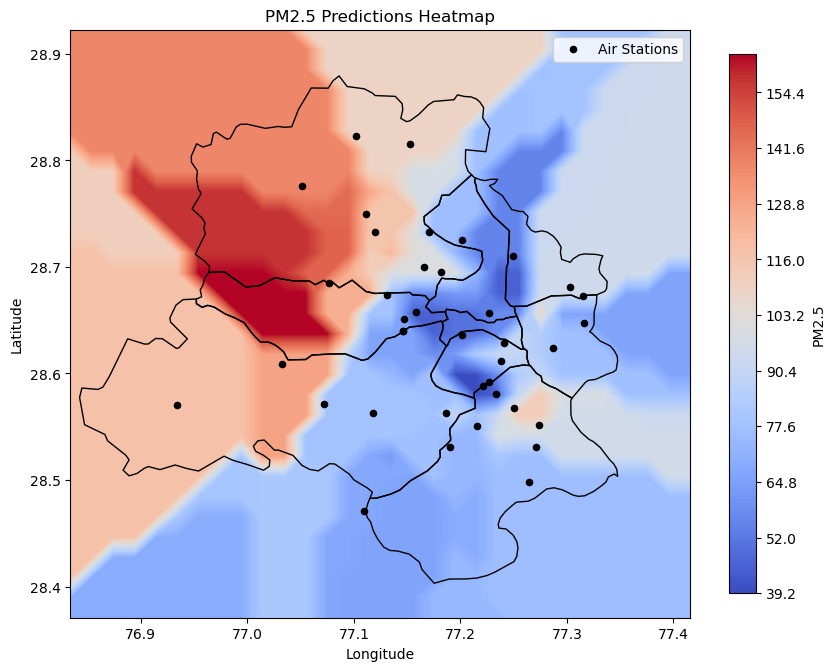

2022-04-01 00:30:00	27.225307057057055


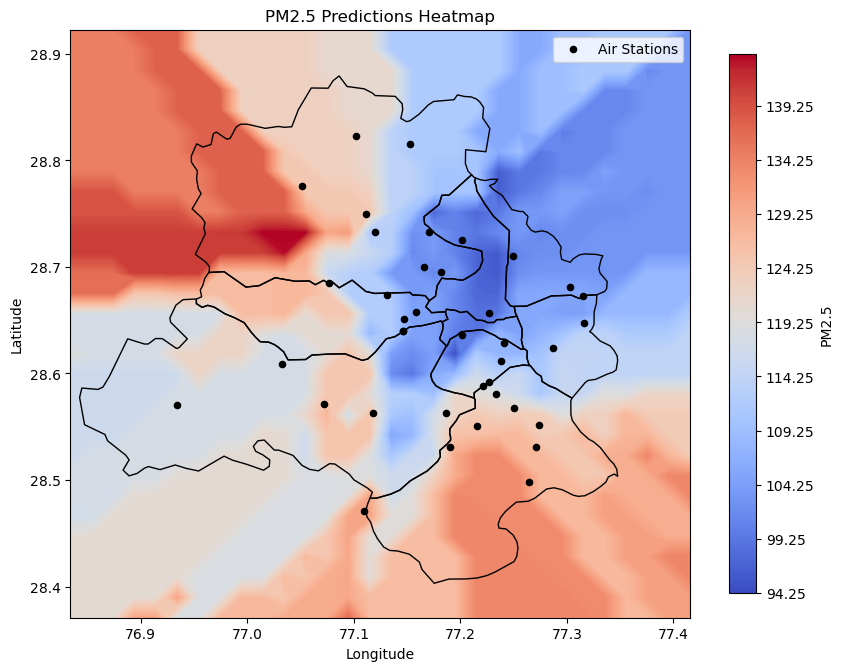

2022-05-01 00:30:00	44.68446929824561


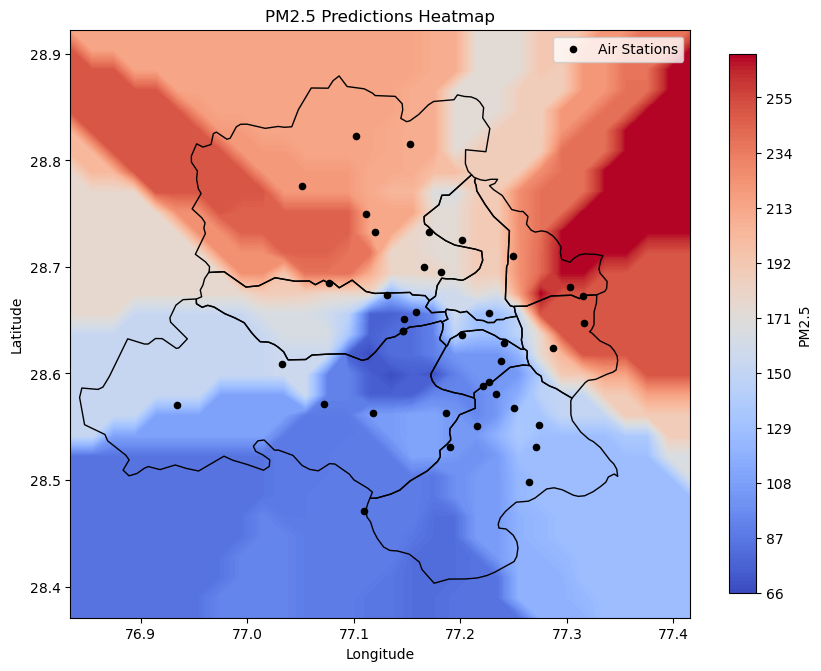

2022-06-01 00:30:00	38.28161403508771


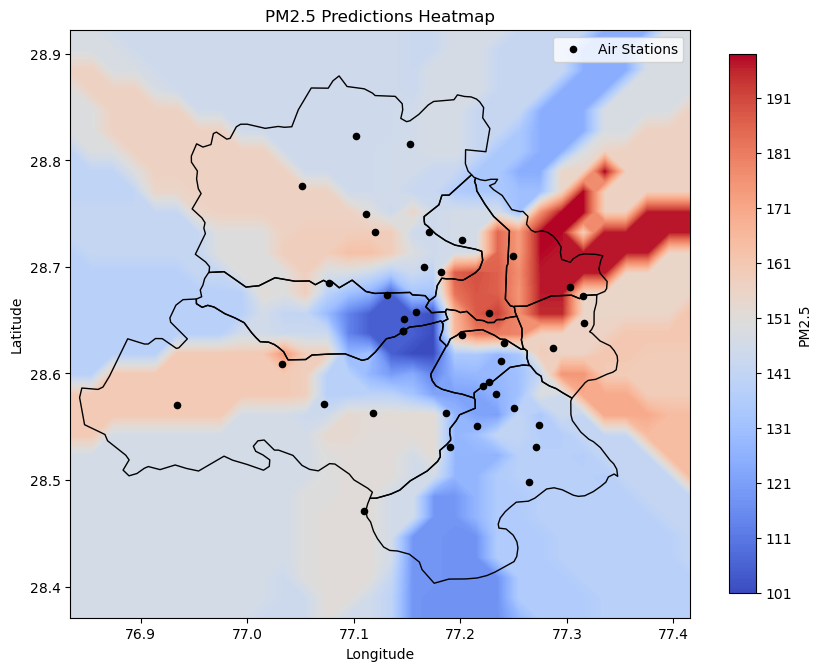

2022-07-01 00:30:00	7.977205882352941


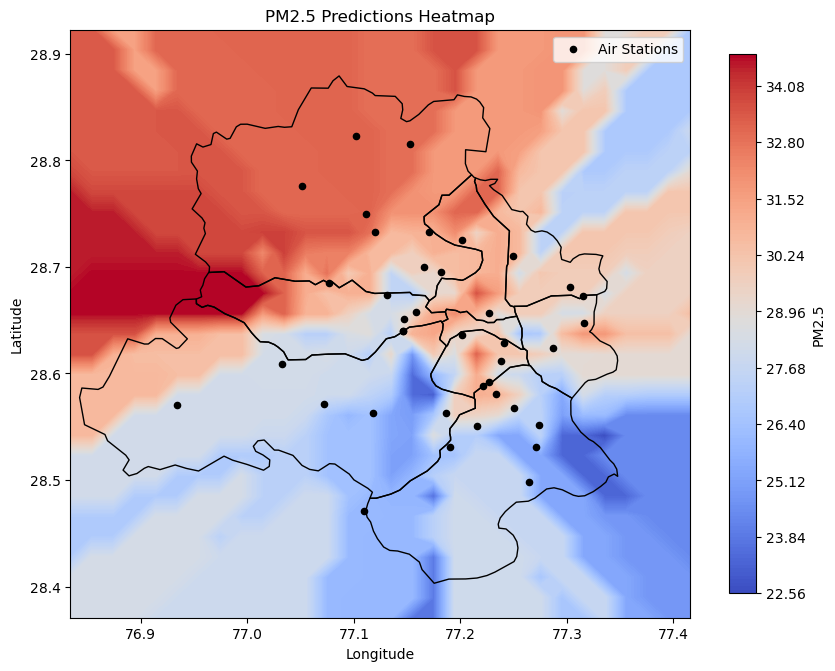

2022-08-01 00:30:00	13.491081081081083


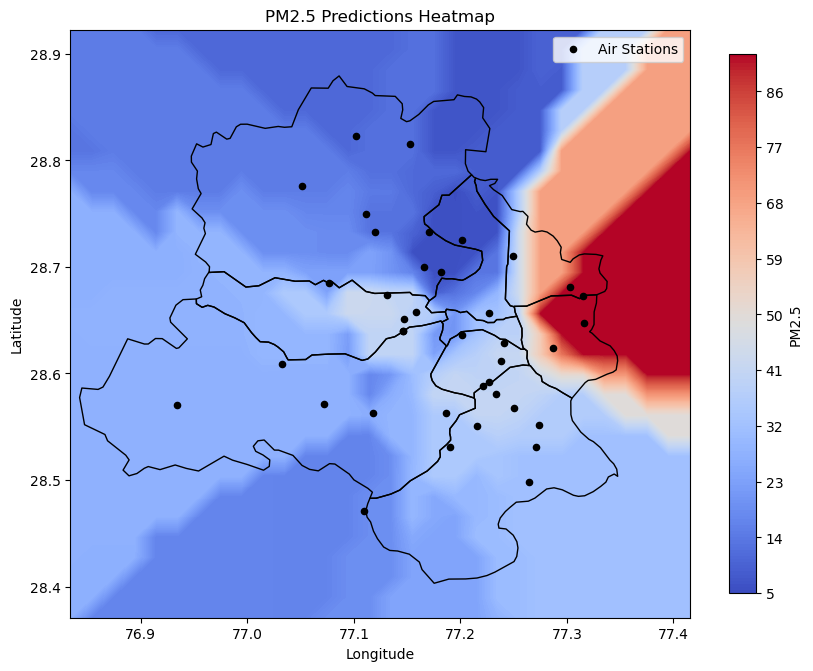

2022-09-01 00:30:00	12.58188038548753


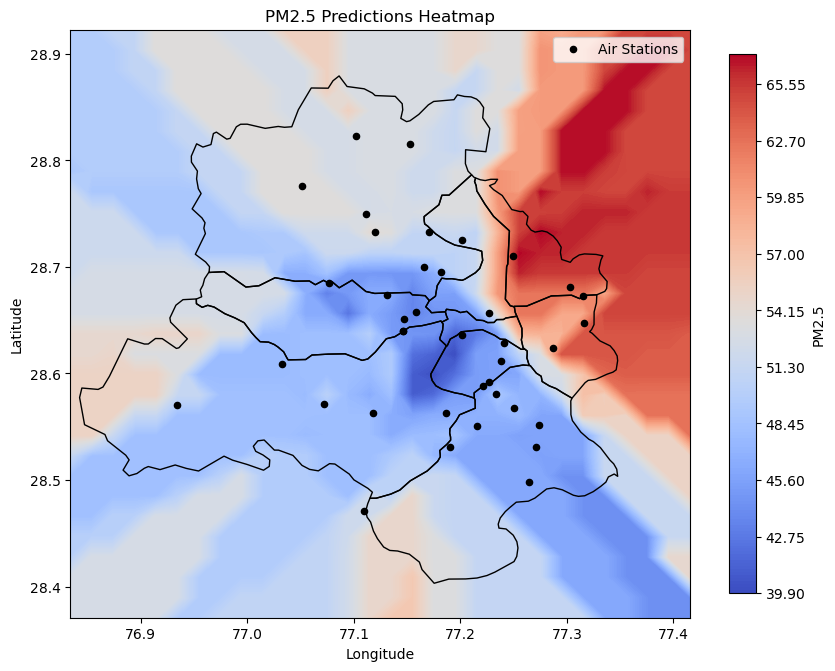

2022-10-01 00:30:00	20.546206916099774


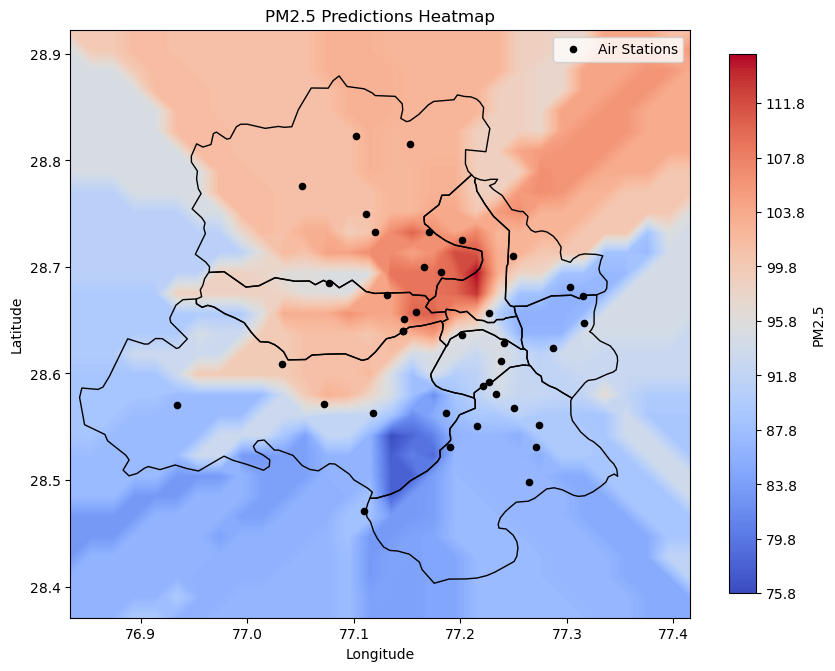

2022-11-01 00:30:00	97.78524088374087


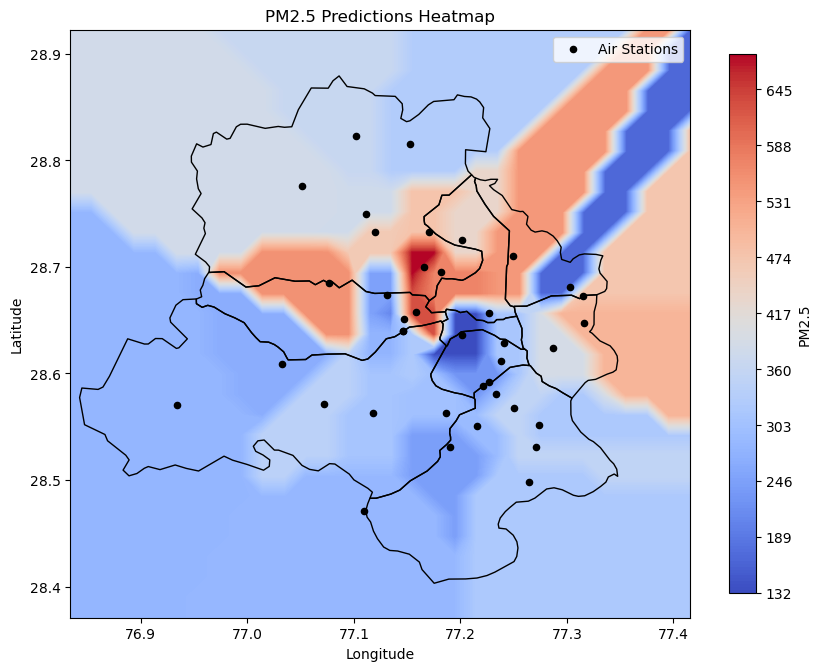

2022-12-01 00:30:00	51.93239489489489


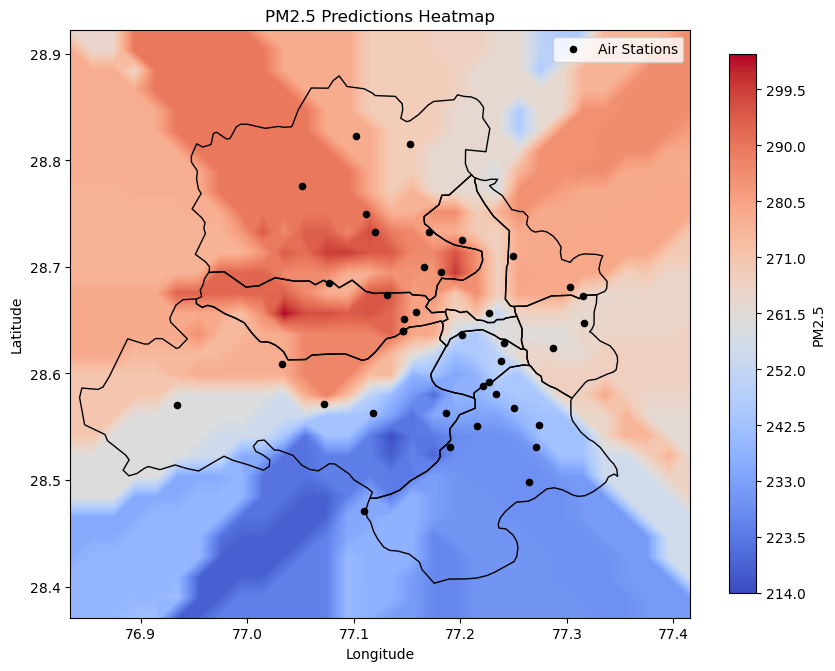

In [4]:
p = pd.date_range(start='2022-01-01 00:30:00', end='2022-12-01 00:30:00', freq = '1MS').to_frame(name='dates')
knn_rmse = []
knn_preds = []

for i in p['dates']:
    df = df_[df_["time"]==i]
    df = df.dropna(subset=["PM2.5"])
    print(i, end = '\t')
    knn_rmse_i = []
    
    #Leave One Out Cross Validation
    for station in df.station.unique():
        train = df[df['station'] != station]
        test = df[df['station'] == station]
        X_train = train[['latitude', 'longitude']]
        X_test = test[['latitude', 'longitude']]
        y_train = train['PM2.5']
        y_test = test['PM2.5']
        pred = knn(X_train, y_train, X_test)
        knn_rmse_i.append(np.sqrt((y_test - pred)**2))
    
    #RMSE
    knn_rmse.append(np.mean(knn_rmse_i))
    print(knn_rmse[-1])
    
    #Heatmap
    latitudes = np.array(df['latitude'])
    longitudes = np.array(df['longitude'])
    g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
    g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)
    lat_grid, lon_grid = np.meshgrid(g_lat, g_long)
    
    train = df[['latitude', 'longitude', 'PM2.5']]
    test = pd.DataFrame({'longitude':lon_grid.flatten(),
                     'latitude':lat_grid.flatten()})
    
    X_train = train[['latitude', 'longitude']]
    y_train = train['PM2.5']
    X_test = test[['latitude', 'longitude']]
    
    preds = knn(X_train, y_train, X_test)
    test['PM2.5'] = preds
    heatmap.plot_heatmap(lon = np.array(test['longitude']), lat = np.array(test['latitude']), values = test['PM2.5'].values)